In [1]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
using DiffEqFlux
using Optim
using ForwardDiff

In [2]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const * (M + M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

In [3]:
# function limit_func(param,pmin,pmax)
#     PL = pmax - pmin
#     offset = 0.5*(pmax + pmin)
#     PL/2 * (sin(pi * (param - offset)/PL) + 1) + pmin
# end
function limit_func(param,pmin,pmax)
    if pmin < param < pmax
        return param
    elseif param <= pmin
        return pmin
    else
        return pmax
    end
end

limit_func (generic function with 1 method)

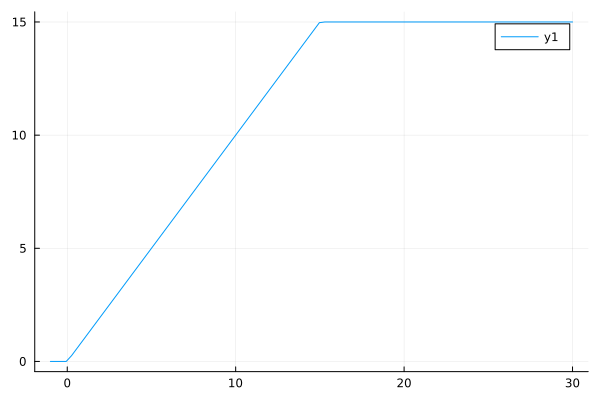

In [4]:
lims = (0,15)
tmpx = LinRange(lims[1]-1, 2*lims[2], 100)
plot(tmpx, [limit_func(x,lims[1],lims[2]) for x in tmpx])

In [5]:
#[Tᵣ, Tₐ, Tₚ, αmin, ϕ, f, A, Φ_ext, λ]
p = [2, 10, 10, 0.7, 0.5418, 0.9763, 1.01556, 0.995pi, 0.05289]

function alpha(p, t)
    Tₐ = limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    αmin = limit_func(p[4],0.5,1)
    abs_slope = (1 - αmin)/Tₐ
    if t < Tₐ
        return 1 - abs_slope * t
    elseif t > Tₐ + Tₚ
        return αmin + abs_slope * (t - Tₐ - Tₚ)
    else
        return αmin
    end
end

dalphadp(p, t) = ForwardDiff.gradient(p̃ -> alpha(p̃,t), p)

function envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    if Tₐ < t < Tₐ + Tᵣ
        arg = pi / 2 * (t - Tₐ) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*pi/(2*Tᵣ)
    elseif Tₐ + Tᵣ < t < Tₐ + Tₚ - Tᵣ
        E *= 1
        Edot *= 0
    elseif Tₐ + Tₚ - Tᵣ < t < Tₐ + Tₚ
        arg = pi / 2 * (Tₐ + Tₚ - t) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*(-pi)/(2*Tᵣ)
    else
        E *= 0
        Edot *= 0
    end
    return (E, Edot)
end

function pulse(p, t, ω_qubit, overlap_scale)
    Tₐ = limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    Tᵣ = limit_func(p[1],0,Tₚ/2)
    # αmin = p[4]
    ϕ = p[5]
    f = p[6]
    A = p[7]
    # Φ_ext = p[8]
    λ = p[9]

    amp = pi * A / ((Tₚ - Tᵣ) * overlap_scale)
    E = amp
    Edot = amp
    E, Edot = envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    arg = f*ω_qubit*(t - Tₐ) + ϕ
    return E*cos(arg) + Edot*λ*sin(arg)
end

dpulsedp(p, t, ω_qubit, overlap_scale) = ForwardDiff.gradient(p̃ -> pulse(p̃, t, ω_qubit, overlap_scale), p)

dpulsedp (generic function with 1 method)

In [6]:
# Es, ψs = eigs(KinPot12 + p[4] .* get_Pot3(p[8]), nev=2, which=:SR)
# ω_qubit = real(Es[2] - Es[1])
# overlap_scale = abs(ψs[:,2]' * chargecoupling * ψs[:,1])

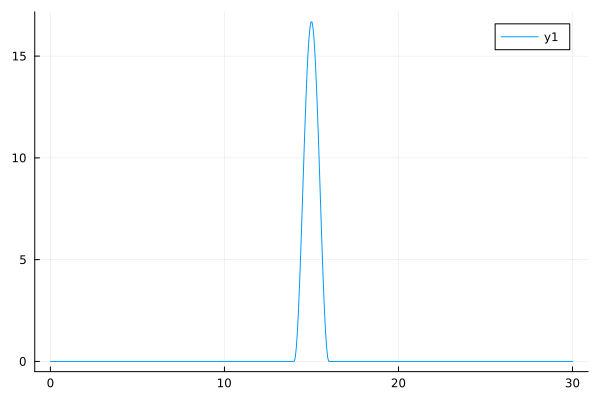

In [7]:
times = LinRange(0,30.0,500)

plot(times,[pulse([10, 14, 0, 0.7, 0.0, 0.0, 1.33, phi_ext, 0],t,1, 0.25) for t in times])

In [8]:
function wrapper_augmented_H_int!(buffer)
    Potential3 = buffer[3]
    ω_qubit = buffer[1]
    overlap_scale = buffer[2]
    function augmented_H_int!(du, u, p, t)
        H = KinPot12 + alpha(p, t) .* Potential3
        V = chargecoupling
        hamil = H + pulse(p, t, ω_qubit, overlap_scale) .* V
        
        a = transpose(reshape(u[1:2*NHilbert],NHilbert,2))
        ψT = reshape(u[2*NHilbert+1:4*NHilbert],NHilbert,2)
        # a = reshape(u[1:NHilbert],1,:)
        # ψT = u[NHilbert+1:2*NHilbert]

        du[1:2*NHilbert] = reshape(transpose(im .* a * hamil),:)
        du[2*NHilbert+1:4*NHilbert] = reshape(-im .* hamil * ψT,:)
        # du[1:NHilbert] = im .* a * hamil
        # du[NHilbert+1:2*NHilbert] = -im .* hamil * ψT
        
        du[4*NHilbert+1:end] = 2*real(im * tr(a * V * ψT)) .* dpulsedp(p, t, ω_qubit, overlap_scale) + 2*real(im * tr(a * Potential3 * ψT)) .* dalphadp(p,t)
        # du[2*NHilbert+1:end] = 2*real(im * a * V * ψT) .* dpulsedp(p, t, ω_qubit, overlap_scale) + 2*real(im * a * Potential3 * ψT) .* dalphadp(p,t)
    end
    return augmented_H_int!
end

wrapper_augmented_H_int! (generic function with 1 method)

In [9]:
#buffer = [ω_qubit, overlap_scale, Potential3, ψ1s, ψT]
function wrapper_H_int!(buffer)
    Potential3 = buffer[3]
    ω_qubit = buffer[1]
    overlap_scale = buffer[2]
    function H_int!(du, u, p, t)
        H = KinPot12 + alpha(p, t) .* Potential3
        V = pulse(p, t, ω_qubit, overlap_scale) .* chargecoupling
        du[:] = - im * (H + V) * u
    end
    return H_int!
end

function calculate_common!(p, last_p, buffer)
    if p != last_p
        copy!(last_p, p)
        println(last_p)
        buffer[3] = get_Pot3(0.995pi)#p[8])
        Es, ψs = eigs(KinPot12 + p[4] .* buffer[3], nev=2, which=:SR)
        buffer[1] = real(Es[2] - Es[1])
        buffer[2] = abs(ψs[:,2]' * chargecoupling * ψs[:,1])

        E1s, ψ1s = eigs(KinPot12 + buffer[3], nev=2, which=:SR)
        buffer[4] = ψ1s
        T = 30.0#p[3] + 2*p[2]
        forward_prob = ODEProblem(wrapper_H_int!(buffer), ψ1s[:,1:2], (0.0, T), p)
        sol = solve(forward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-10)
        buffer[5] = sol.u[end]
    end
end

function loss_func(buffer)
    UT = abs2.(buffer[4]'*buffer[5])
    return 0.5 * (2 - UT[1,2] - UT[2,1])
end

function f(p, last_p, buffer)
    calculate_common!(p, last_p, buffer)
    loss_func(buffer)
end

function g!(storage, p, last_p, buffer)
    calculate_common!(p, last_p, buffer)
    ψT = buffer[5]
    ψ1s = buffer[4]
    a1 = - dropdims(ψT[:,1]'*ψ1s[:,2]*ψ1s[:,2]',dims=1)
    a2 = - dropdims(ψT[:,2]'*ψ1s[:,1]*ψ1s[:,1]',dims=1)

    u0_aug = cat(a1,a2,ψT[:,1],ψT[:,2],zeros(ComplexF64,length(p)),dims=1)
    # u0_aug = cat(a1,ψT[:,1],zeros(ComplexF64,length(p)),dims=1)
    aug_prob = ODEProblem(wrapper_augmented_H_int!(buffer), u0_aug, (30.0,0.0), p)
    aug_sol = solve(aug_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-10)

    # push!(buffer,aug_sol)
    storage[:] = real(aug_sol.u[end][4*NHilbert+1:end])
    # storage[:] = real(aug_sol.u[end][2*NHilbert+1:end])
end

g! (generic function with 1 method)

In [12]:
initial_p = copy(p)
buffer = [0,0,zeros(ComplexF64,NHilbert,NHilbert),zeros(ComplexF64,NHilbert,2),zeros(ComplexF64,NHilbert,2)]
last_p = similar(initial_p);

In [11]:
storage = similar(last_p)
g!(storage,p,last_p,buffer)

[2.0, 10.0, 10.0, 0.7, 0.5418, 0.9763, 1.01556, 3.1258846903218442, 0.05289]


9-element Vector{Float64}:
 -0.00020829795135391636
 -0.001040287728119898
  0.0
  0.006333617663564399
 -1.051421487891023e-6
  0.00037007594173809233
  2.1200140831049008e-6
  0.0
  2.3583576674600797e-5

In [13]:
res = optimize(p -> f(p, initial_p, buffer),
               (storage, p) -> g!(storage, p, last_p, buffer),
               initial_p,BFGS())

[2.0, 10.0, 10.0, 0.7, 0.5418, 0.9763, 1.01556, 3.1258846903218442, 0.05289]


[2.0002083068534513, 10.00104030811585, 10.0, 0.6936663816996786, 0.5418010514280106, 0.9759299240462633, 1.015557879993325, 3.1258846903218442, 0.05286641643980978]


[2.0002083068534513, 10.00104030811585, 10.0, 0.6936663816996786, 0.5418010514280106, 0.9759299240462633, 1.015557879993325, 3.1258846903218442, 0.05286641643980978]


[2.0000058654406137, 10.000029292677473, 10.0, 0.6998216599147122, 0.541800029605788, 0.9762895795145803, 1.0155599403055011, 3.1258846903218442, 0.05288933594133143]


[2.0000058654406137, 10.000029292677473, 10.0, 0.6998216599147122, 0.541800029605788, 0.9762895795145803, 1.0155599403055011, 3.1258846903218442, 0.05288933594133143]


[2.0000005054428396, 10.000002524239024, 10.0, 0.6999846318929666, 0.5418000025512206, 0.9762991020351088, 1.0155599948559437, 3.1258846903218442, 0.0528899427760468]


[2.0000005054428396, 10.000002524239024, 10.0, 0.6999846318929666, 0.5418000025512206, 0.9762991020351088, 1.0155599948559437, 3.1258846903218442, 0.0528899427760468]


[2.0002201742535064, 10.001156015905055, 10.0, 0.6998091057078664, 0.5417797907837908, 0.9770531007874951, 1.0160062334391886, 3.1258846903218442, 0.052958775017298884]


[2.0002201742535064, 10.001156015905055, 10.0, 0.6998091057078664, 0.5417797907837908, 0.9770531007874951, 1.0160062334391886, 3.1258846903218442, 0.052958775017298884]


[2.000110339848173, 10.00057927007204, 10.0, 0.6998968688004165, 0.5417898966675057, 0.976676101411302, 1.0157831141475662, 3.1258846903218442, 0.052924358896672845]


[2.000110339848173, 10.00057927007204, 10.0, 0.6998968688004165, 0.5417898966675057, 0.976676101411302, 1.0157831141475662, 3.1258846903218442, 0.052924358896672845]


[2.0000554226455063, 10.000290897155532, 10.0, 0.6999407503466915, 0.5417949496093631, 0.9764876017232054, 1.015671554501755, 3.1258846903218442, 0.05290715083635982]


[2.0000554226455063, 10.000290897155532, 10.0, 0.6999407503466915, 0.5417949496093631, 0.9764876017232054, 1.015671554501755, 3.1258846903218442, 0.05290715083635982]


[2.0000279640441727, 10.000146710697278, 10.0, 0.699962691119829, 0.5417974760802919, 0.9763933518791571, 1.0156157746788494, 3.1258846903218442, 0.05289854680620331]


[2.0000279640441727, 10.000146710697278, 10.0, 0.699962691119829, 0.5417974760802919, 0.9763933518791571, 1.0156157746788494, 3.1258846903218442, 0.05289854680620331]


[2.000014234743506, 10.000074617468151, 10.0, 0.6999736615063978, 0.5417987393157563, 0.976346226957133, 1.0155878847673965, 3.1258846903218442, 0.052894244791125054]


[2.000014234743506, 10.000074617468151, 10.0, 0.6999736615063978, 0.5417987393157563, 0.976346226957133, 1.0155878847673965, 3.1258846903218442, 0.052894244791125054]


[2.0000210993938397, 10.000110664082714, 10.0, 0.6999681763131134, 0.5417981076980241, 0.976369789418145, 1.0156018297231229, 3.1258846903218442, 0.05289639579866418]


[2.0000210993938397, 10.000110664082714, 10.0, 0.6999681763131134, 0.5417981076980241, 0.976369789418145, 1.0156018297231229, 3.1258846903218442, 0.05289639579866418]


[2.000017667068673, 10.000092640775433, 10.0, 0.6999709189097556, 0.5417984235068902, 0.976358008187639, 1.0155948572452598, 3.1258846903218442, 0.05289532029489462]


[2.000017667068673, 10.000092640775433, 10.0, 0.6999709189097556, 0.5417984235068902, 0.976358008187639, 1.0155948572452598, 3.1258846903218442, 0.05289532029489462]


[2.0000159509060897, 10.000083629121791, 10.0, 0.6999722902080767, 0.5417985814113232, 0.976352117572386, 1.0155913710063282, 3.1258846903218442, 0.05289478254300983]


[2.0000159509060897, 10.000083629121791, 10.0, 0.6999722902080767, 0.5417985814113232, 0.976352117572386, 1.0155913710063282, 3.1258846903218442, 0.05289478254300983]


[2.000015092824798, 10.000079123294972, 10.0, 0.6999729758572373, 0.5417986603635397, 0.9763491722647595, 1.0155896278868624, 3.1258846903218442, 0.05289451366706745]


[2.000015092824798, 10.000079123294972, 10.0, 0.6999729758572373, 0.5417986603635397, 0.9763491722647595, 1.0155896278868624, 3.1258846903218442, 0.05289451366706745]


[2.0000146637841523, 10.00007687038156, 10.0, 0.6999733186818176, 0.541798699839648, 0.9763476996109463, 1.0155887563271295, 3.1258846903218442, 0.05289437922909625]


[2.0000146637841523, 10.00007687038156, 10.0, 0.6999733186818176, 0.541798699839648, 0.9763476996109463, 1.0155887563271295, 3.1258846903218442, 0.05289437922909625]


[2.000014449263829, 10.000075743924857, 10.0, 0.6999734900941077, 0.5417987195777021, 0.9763469632840396, 1.015588320547263, 3.1258846903218442, 0.052894312010110654]


[2.000014449263829, 10.000075743924857, 10.0, 0.6999734900941077, 0.5417987195777021, 0.9763469632840396, 1.015588320547263, 3.1258846903218442, 0.052894312010110654]


[2.000014342003668, 10.000075180696504, 10.0, 0.6999735758002528, 0.5417987294467292, 0.9763465951205863, 1.0155881026573297, 3.1258846903218442, 0.052894278400617854]


[2.000014342003668, 10.000075180696504, 10.0, 0.6999735758002528, 0.5417987294467292, 0.9763465951205863, 1.0155881026573297, 3.1258846903218442, 0.052894278400617854]


[2.0000143956337486, 10.00007546231068, 10.0, 0.6999735329471802, 0.5417987245122157, 0.9763467792023129, 1.0155882116022963, 3.1258846903218442, 0.052894295205364254]


[2.0000143956337486, 10.00007546231068, 10.0, 0.6999735329471802, 0.5417987245122157, 0.9763467792023129, 1.0155882116022963, 3.1258846903218442, 0.052894295205364254]


[2.000014422448789, 10.000075603117768, 10.0, 0.6999735115206439, 0.5417987220449589, 0.9763468712431763, 1.0155882660747797, 3.1258846903218442, 0.052894303607737454]


[2.000014422448789, 10.000075603117768, 10.0, 0.6999735115206439, 0.5417987220449589, 0.9763468712431763, 1.0155882660747797, 3.1258846903218442, 0.052894303607737454]


[2.000014435856309, 10.000075673521312, 10.0, 0.6999735008073757, 0.5417987208113305, 0.9763469172636079, 1.0155882933110214, 3.1258846903218442, 0.052894307808924054]


[2.000014435856309, 10.000075673521312, 10.0, 0.6999735008073757, 0.5417987208113305, 0.9763469172636079, 1.0155882933110214, 3.1258846903218442, 0.052894307808924054]


[2.000014442560069, 10.000075708723084, 10.0, 0.6999734954507417, 0.5417987201945164, 0.9763469402738237, 1.0155883069291423, 3.1258846903218442, 0.05289430990951735]


[2.000014442560069, 10.000075708723084, 10.0, 0.6999734954507417, 0.5417987201945164, 0.9763469402738237, 1.0155883069291423, 3.1258846903218442, 0.05289430990951735]


[2.0000144459119493, 10.00007572632397, 10.0, 0.6999734927724247, 0.5417987198861093, 0.9763469517789317, 1.0155883137382025, 3.1258846903218442, 0.052894310959814]


[2.0000144459119493, 10.00007572632397, 10.0, 0.6999734927724247, 0.5417987198861093, 0.9763469517789317, 1.0155883137382025, 3.1258846903218442, 0.052894310959814]


[2.000014444236009, 10.000075717523528, 10.0, 0.6999734941115832, 0.5417987200403128, 0.9763469460263777, 1.0155883103336725, 3.1258846903218442, 0.05289431043466568]


[2.000014444236009, 10.000075717523528, 10.0, 0.6999734941115832, 0.5417987200403128, 0.9763469460263777, 1.0155883103336725, 3.1258846903218442, 0.05289431043466568]


[2.000014445073979, 10.000075721923748, 10.0, 0.699973493442004, 0.541798719963211, 0.9763469489026547, 1.0155883120359375, 3.1258846903218442, 0.05289431069723984]


[2.000014445073979, 10.000075721923748, 10.0, 0.699973493442004, 0.541798719963211, 0.9763469489026547, 1.0155883120359375, 3.1258846903218442, 0.05289431069723984]


[2.000014445492964, 10.000075724123858, 10.0, 0.6999734931072144, 0.5417987199246601, 0.9763469503407932, 1.01558831288707, 3.1258846903218442, 0.05289431082852692]


[2.000014445492964, 10.000075724123858, 10.0, 0.6999734931072144, 0.5417987199246601, 0.9763469503407932, 1.01558831288707, 3.1258846903218442, 0.05289431082852692]


[2.0000144457024565, 10.000075725223915, 10.0, 0.6999734929398195, 0.5417987199053846, 0.9763469510598625, 1.0155883133126362, 3.1258846903218442, 0.05289431089417046]


[2.0000144457024565, 10.000075725223915, 10.0, 0.6999734929398195, 0.5417987199053846, 0.9763469510598625, 1.0155883133126362, 3.1258846903218442, 0.05289431089417046]


[2.0000144455977105, 10.000075724673886, 10.0, 0.699973493023517, 0.5417987199150224, 0.9763469507003278, 1.015588313099853, 3.1258846903218442, 0.052894310861348694]


[2.0000144455977105, 10.000075724673886, 10.0, 0.699973493023517, 0.5417987199150224, 0.9763469507003278, 1.015588313099853, 3.1258846903218442, 0.052894310861348694]


[2.0000144455453372, 10.000075724398872, 10.0, 0.6999734930653656, 0.5417987199198413, 0.9763469505205605, 1.0155883129934615, 3.1258846903218442, 0.05289431084493781]


[2.0000144455453372, 10.000075724398872, 10.0, 0.6999734930653656, 0.5417987199198413, 0.9763469505205605, 1.0155883129934615, 3.1258846903218442, 0.05289431084493781]


[2.0000144455191506, 10.000075724261366, 10.0, 0.69997349308629, 0.5417987199222507, 0.9763469504306769, 1.0155883129402659, 3.1258846903218442, 0.052894310836732364]


[2.0000144455191506, 10.000075724261366, 10.0, 0.69997349308629, 0.5417987199222507, 0.9763469504306769, 1.0155883129402659, 3.1258846903218442, 0.052894310836732364]


[2.0000144455060576, 10.000075724192612, 10.0, 0.6999734930967522, 0.5417987199234554, 0.976346950385735, 1.015588312913668, 3.1258846903218442, 0.05289431083262964]


[2.0000144455060576, 10.000075724192612, 10.0, 0.6999734930967522, 0.5417987199234554, 0.976346950385735, 1.015588312913668, 3.1258846903218442, 0.05289431083262964]


[2.000014445512604, 10.00007572422699, 10.0, 0.699973493091521, 0.541798719922853, 0.976346950408206, 1.015588312926967, 3.1258846903218442, 0.052894310834681005]


[2.000014445512604, 10.00007572422699, 10.0, 0.699973493091521, 0.541798719922853, 0.976346950408206, 1.015588312926967, 3.1258846903218442, 0.052894310834681005]


[2.0000144455158773, 10.000075724244178, 10.0, 0.6999734930889056, 0.5417987199225519, 0.9763469504194414, 1.0155883129336163, 3.1258846903218442, 0.052894310835706684]


[2.0000144455158773, 10.000075724244178, 10.0, 0.6999734930889056, 0.5417987199225519, 0.9763469504194414, 1.0155883129336163, 3.1258846903218442, 0.052894310835706684]


[2.000014445517514, 10.000075724252772, 10.0, 0.6999734930875977, 0.5417987199224013, 0.9763469504250591, 1.015588312936941, 3.1258846903218442, 0.052894310836219524]


[2.000014445517514, 10.000075724252772, 10.0, 0.6999734930875977, 0.5417987199224013, 0.9763469504250591, 1.015588312936941, 3.1258846903218442, 0.052894310836219524]


[2.0000144455166957, 10.000075724248475, 10.0, 0.6999734930882516, 0.5417987199224765, 0.9763469504222503, 1.0155883129352787, 3.1258846903218442, 0.052894310835963104]


[2.0000144455166957, 10.000075724248475, 10.0, 0.6999734930882516, 0.5417987199224765, 0.9763469504222503, 1.0155883129352787, 3.1258846903218442, 0.052894310835963104]


[2.0000144455162867, 10.000075724246326, 10.0, 0.6999734930885786, 0.5417987199225142, 0.9763469504208458, 1.0155883129344476, 3.1258846903218442, 0.052894310835834894]


[2.0000144455162867, 10.000075724246326, 10.0, 0.6999734930885786, 0.5417987199225142, 0.9763469504208458, 1.0155883129344476, 3.1258846903218442, 0.052894310835834894]


[2.000014445516082, 10.000075724245253, 10.0, 0.699973493088742, 0.541798719922533, 0.9763469504201436, 1.015588312934032, 3.1258846903218442, 0.052894310835770786]


[2.000014445516082, 10.000075724245253, 10.0, 0.699973493088742, 0.541798719922533, 0.9763469504201436, 1.015588312934032, 3.1258846903218442, 0.052894310835770786]


[2.00001444551598, 10.000075724244715, 10.0, 0.6999734930888237, 0.5417987199225425, 0.9763469504197925, 1.0155883129338241, 3.1258846903218442, 0.052894310835738735]


[2.00001444551598, 10.000075724244715, 10.0, 0.6999734930888237, 0.5417987199225425, 0.9763469504197925, 1.0155883129338241, 3.1258846903218442, 0.052894310835738735]


[2.0000144455159283, 10.000075724244446, 10.0, 0.6999734930888647, 0.5417987199225471, 0.9763469504196169, 1.0155883129337202, 3.1258846903218442, 0.052894310835722706]


[2.0000144455159283, 10.000075724244446, 10.0, 0.6999734930888647, 0.5417987199225471, 0.9763469504196169, 1.0155883129337202, 3.1258846903218442, 0.052894310835722706]


[2.000014445515954, 10.000075724244581, 10.0, 0.6999734930888442, 0.5417987199225448, 0.9763469504197048, 1.0155883129337722, 3.1258846903218442, 0.05289431083573072]


[2.000014445515954, 10.000075724244581, 10.0, 0.6999734930888442, 0.5417987199225448, 0.9763469504197048, 1.0155883129337722, 3.1258846903218442, 0.05289431083573072]


[2.000014445515941, 10.000075724244514, 10.0, 0.6999734930888545, 0.541798719922546, 0.9763469504196608, 1.0155883129337462, 3.1258846903218442, 0.05289431083572672]


[2.000014445515941, 10.000075724244514, 10.0, 0.6999734930888545, 0.541798719922546, 0.9763469504196608, 1.0155883129337462, 3.1258846903218442, 0.05289431083572672]


[2.000014445515948, 10.000075724244548, 10.0, 0.6999734930888494, 0.5417987199225454, 0.9763469504196828, 1.0155883129337593, 3.1258846903218442, 0.05289431083572872]


[2.000014445515948, 10.000075724244548, 10.0, 0.6999734930888494, 0.5417987199225454, 0.9763469504196828, 1.0155883129337593, 3.1258846903218442, 0.05289431083572872]


[2.000014445515951, 10.000075724244564, 10.0, 0.6999734930888467, 0.5417987199225451, 0.9763469504196938, 1.0155883129337657, 3.1258846903218442, 0.05289431083572972]


[2.000014445515951, 10.000075724244564, 10.0, 0.6999734930888467, 0.5417987199225451, 0.9763469504196938, 1.0155883129337657, 3.1258846903218442, 0.05289431083572972]


[2.000014445515949, 10.000075724244555, 10.0, 0.699973493088848, 0.5417987199225452, 0.9763469504196882, 1.0155883129337624, 3.1258846903218442, 0.05289431083572922]


[2.000014445515949, 10.000075724244555, 10.0, 0.699973493088848, 0.5417987199225452, 0.9763469504196882, 1.0155883129337624, 3.1258846903218442, 0.05289431083572922]


[2.00001444551595, 10.00007572424456, 10.0, 0.6999734930888474, 0.5417987199225451, 0.976346950419691, 1.0155883129337642, 3.1258846903218442, 0.05289431083572947]


[2.00001444551595, 10.00007572424456, 10.0, 0.6999734930888474, 0.5417987199225451, 0.976346950419691, 1.0155883129337642, 3.1258846903218442, 0.05289431083572947]


[2.0000144455159496, 10.000075724244558, 10.0, 0.6999734930888477, 0.5417987199225452, 0.9763469504196897, 1.0155883129337633, 3.1258846903218442, 0.05289431083572935]


[2.0000144455159496, 10.000075724244558, 10.0, 0.6999734930888477, 0.5417987199225452, 0.9763469504196897, 1.0155883129337633, 3.1258846903218442, 0.05289431083572935]


[2.00001444551595, 10.000075724244558, 10.0, 0.6999734930888476, 0.5417987199225451, 0.9763469504196903, 1.0155883129337637, 3.1258846903218442, 0.05289431083572941]


[2.00001444551595, 10.000075724244558, 10.0, 0.6999734930888476, 0.5417987199225451, 0.9763469504196903, 1.0155883129337637, 3.1258846903218442, 0.05289431083572941]


[2.0000144455159496, 10.000075724244558, 10.0, 0.6999734930888476, 0.5417987199225452, 0.97634695041969, 1.0155883129337635, 3.1258846903218442, 0.052894310835729375]


[2.0000144455159496, 10.000075724244558, 10.0, 0.6999734930888476, 0.5417987199225452, 0.97634695041969, 1.0155883129337635, 3.1258846903218442, 0.052894310835729375]


[2.0000144455159496, 10.000075724244558, 10.0, 0.6999734930888477, 0.5417987199225452, 0.9763469504196898, 1.0155883129337633, 3.1258846903218442, 0.05289431083572936]


[2.0000144455159496, 10.000075724244558, 10.0, 0.6999734930888477, 0.5417987199225452, 0.9763469504196898, 1.0155883129337633, 3.1258846903218442, 0.05289431083572936]


[2.0000144455159496, 10.000075724244558, 10.0, 0.6999734930888477, 0.5417987199225452, 0.9763469504196899, 1.0155883129337635, 3.1258846903218442, 0.05289431083572937]


[2.0000144455159496, 10.000075724244558, 10.0, 0.6999734930888477, 0.5417987199225452, 0.9763469504196899, 1.0155883129337635, 3.1258846903218442, 0.05289431083572937]


[2.0000144455159496, 10.000075724244558, 10.0, 0.6999734930888476, 0.5417987199225452, 0.97634695041969, 1.0155883129337635, 3.1258846903218442, 0.052894310835729375]


[2.0000144455159496, 10.000075724244558, 10.0, 0.6999734930888476, 0.5417987199225452, 0.97634695041969, 1.0155883129337635, 3.1258846903218442, 0.052894310835729375]


[2.0000144455159496, 10.000075724244558, 10.0, 0.6999734930888477, 0.5417987199225452, 0.9763469504196899, 1.0155883129337635, 3.1258846903218442, 0.05289431083572937]


[2.0000144455159496, 10.000075724244558, 10.0, 0.6999734930888477, 0.5417987199225452, 0.9763469504196899, 1.0155883129337635, 3.1258846903218442, 0.05289431083572937]


[2.00022871169967, 10.001620055169598, 10.0, 0.6992628278063817, 0.5416470942095111, 0.978259060255575, 1.019145367712417, 3.1258846903218442, 0.05318419399522119]


[2.00022871169967, 10.001620055169598, 10.0, 0.6992628278063817, 0.5416470942095111, 0.978259060255575, 1.019145367712417, 3.1258846903218442, 0.05318419399522119]


[2.00012157860781, 10.000847889707078, 10.0, 0.6996181604476147, 0.5417229070660282, 0.9773030053376324, 1.0173668403230902, 3.1258846903218442, 0.05303925241547528]


[2.00012157860781, 10.000847889707078, 10.0, 0.6996181604476147, 0.5417229070660282, 0.9773030053376324, 1.0173668403230902, 3.1258846903218442, 0.05303925241547528]


[2.0000680120618797, 10.000461806975817, 10.0, 0.6997958267682312, 0.5417608134942867, 0.9768249778786612, 1.0164775766284269, 3.1258846903218442, 0.052966781625602324]


[2.0000680120618797, 10.000461806975817, 10.0, 0.6997958267682312, 0.5417608134942867, 0.9768249778786612, 1.0164775766284269, 3.1258846903218442, 0.052966781625602324]


[2.000041228788915, 10.000268765610189, 10.0, 0.6998846599285394, 0.541779766708416, 0.9765859641491755, 1.0160329447810952, 3.1258846903218442, 0.05293054623066584]


[2.000041228788915, 10.000268765610189, 10.0, 0.6998846599285394, 0.541779766708416, 0.9765859641491755, 1.0160329447810952, 3.1258846903218442, 0.05293054623066584]


[2.000027837152432, 10.000172244927374, 10.0, 0.6999290765086936, 0.5417892433154806, 0.9764664572844327, 1.0158106288574293, 3.1258846903218442, 0.05291242853319761]


[2.000027837152432, 10.000172244927374, 10.0, 0.6999290765086936, 0.5417892433154806, 0.9764664572844327, 1.0158106288574293, 3.1258846903218442, 0.05291242853319761]


[2.000021141334191, 10.000123984585965, 10.0, 0.6999512847987707, 0.5417939816190129, 0.9764067038520613, 1.0156994708955964, 3.1258846903218442, 0.052903369684463485]


[2.000021141334191, 10.000123984585965, 10.0, 0.6999512847987707, 0.5417939816190129, 0.9764067038520613, 1.0156994708955964, 3.1258846903218442, 0.052903369684463485]


[2.0000177934250702, 10.000099854415263, 10.0, 0.6999623889438091, 0.541796350770779, 0.9763768271358756, 1.01564389191468, 3.1258846903218442, 0.052898840260096426]


[2.0000177934250702, 10.000099854415263, 10.0, 0.6999623889438091, 0.541796350770779, 0.9763768271358756, 1.01564389191468, 3.1258846903218442, 0.052898840260096426]


[2.00001611947051, 10.00008778932991, 10.0, 0.6999679410163284, 0.5417975353466622, 0.9763618887777827, 1.0156161024242218, 3.1258846903218442, 0.0528965755479129]


[2.00001611947051, 10.00008778932991, 10.0, 0.6999679410163284, 0.5417975353466622, 0.9763618887777827, 1.0156161024242218, 3.1258846903218442, 0.0528965755479129]


[2.00001528249323, 10.000081756787234, 10.0, 0.6999707170525881, 0.5417981276346037, 0.9763544195987363, 1.0156022076789926, 3.1258846903218442, 0.052895443191821136]


[2.00001528249323, 10.000081756787234, 10.0, 0.6999707170525881, 0.5417981276346037, 0.9763544195987363, 1.0156022076789926, 3.1258846903218442, 0.052895443191821136]


[2.00001486400459, 10.000078740515896, 10.0, 0.6999721050707179, 0.5417984237785745, 0.9763506850092131, 1.015595260306378, 3.1258846903218442, 0.05289487701377525]


[2.00001486400459, 10.000078740515896, 10.0, 0.6999721050707179, 0.5417984237785745, 0.9763506850092131, 1.015595260306378, 3.1258846903218442, 0.05289487701377525]


[2.0000146547602697, 10.000077232380228, 10.0, 0.6999727990797828, 0.5417985718505599, 0.9763488177144515, 1.0155917866200708, 3.1258846903218442, 0.052894593924752306]


[2.0000146547602697, 10.000077232380228, 10.0, 0.6999727990797828, 0.5417985718505599, 0.9763488177144515, 1.0155917866200708, 3.1258846903218442, 0.052894593924752306]


[2.0000145501381095, 10.000076478312392, 10.0, 0.6999731460843153, 0.5417986458865526, 0.9763478840670707, 1.0155900497769172, 3.1258846903218442, 0.05289445238024084]


[2.0000145501381095, 10.000076478312392, 10.0, 0.6999731460843153, 0.5417986458865526, 0.9763478840670707, 1.0155900497769172, 3.1258846903218442, 0.05289445238024084]


[2.0000144978270296, 10.000076101278475, 10.0, 0.6999733195865815, 0.5417986829045489, 0.9763474172433803, 1.0155891813553404, 3.1258846903218442, 0.052894381607985104]


[2.0000144978270296, 10.000076101278475, 10.0, 0.6999733195865815, 0.5417986829045489, 0.9763474172433803, 1.0155891813553404, 3.1258846903218442, 0.052894381607985104]


[2.0000144716714896, 10.000075912761517, 10.0, 0.6999734063377145, 0.541798701413547, 0.9763471838315351, 1.015588747144552, 3.1258846903218442, 0.052894346221857236]


[2.0000144716714896, 10.000075912761517, 10.0, 0.6999734063377145, 0.541798701413547, 0.9763471838315351, 1.015588747144552, 3.1258846903218442, 0.052894346221857236]


[2.0000144585937196, 10.000075818503039, 10.0, 0.6999734497132811, 0.5417987106680462, 0.9763470671256125, 1.0155885300391576, 3.1258846903218442, 0.0528943285287933]


[2.0000144585937196, 10.000075818503039, 10.0, 0.6999734497132811, 0.5417987106680462, 0.9763470671256125, 1.0155885300391576, 3.1258846903218442, 0.0528943285287933]


[2.0000144520548346, 10.000075771373798, 10.0, 0.6999734714010645, 0.5417987152952957, 0.9763470087726512, 1.0155884214864606, 3.1258846903218442, 0.05289431968226133]


[2.0000144520548346, 10.000075771373798, 10.0, 0.6999734714010645, 0.5417987152952957, 0.9763470087726512, 1.0155884214864606, 3.1258846903218442, 0.05289431968226133]


[2.000014448785392, 10.000075747809179, 10.0, 0.699973482244956, 0.5417987176089205, 0.9763469795961706, 1.015588367210112, 3.1258846903218442, 0.05289431525899535]


[2.000014448785392, 10.000075747809179, 10.0, 0.699973482244956, 0.5417987176089205, 0.9763469795961706, 1.015588367210112, 3.1258846903218442, 0.05289431525899535]


[2.000014447150671, 10.000075736026869, 10.0, 0.6999734876669019, 0.5417987187657328, 0.9763469650079302, 1.0155883400719379, 3.1258846903218442, 0.05289431304736236]


[2.000014447150671, 10.000075736026869, 10.0, 0.6999734876669019, 0.5417987187657328, 0.9763469650079302, 1.0155883400719379, 3.1258846903218442, 0.05289431304736236]


[2.0000144479680317, 10.000075741918023, 10.0, 0.6999734849559289, 0.5417987181873267, 0.9763469723020504, 1.0155883536410248, 3.1258846903218442, 0.052894314153178856]


[2.0000144479680317, 10.000075741918023, 10.0, 0.6999734849559289, 0.5417987181873267, 0.9763469723020504, 1.0155883536410248, 3.1258846903218442, 0.052894314153178856]


[2.000014448376712, 10.0000757448636, 10.0, 0.6999734836004425, 0.5417987178981236, 0.9763469759491105, 1.0155883604255684, 3.1258846903218442, 0.0528943147060871]


[2.000014448376712, 10.0000757448636, 10.0, 0.6999734836004425, 0.5417987178981236, 0.9763469759491105, 1.0155883604255684, 3.1258846903218442, 0.0528943147060871]


[2.000014448581052, 10.000075746336389, 10.0, 0.6999734829226993, 0.5417987177535221, 0.9763469777726405, 1.0155883638178402, 3.1258846903218442, 0.05289431498254123]


[2.000014448581052, 10.000075746336389, 10.0, 0.6999734829226993, 0.5417987177535221, 0.9763469777726405, 1.0155883638178402, 3.1258846903218442, 0.05289431498254123]


[2.000014448683222, 10.000075747072783, 10.0, 0.6999734825838276, 0.5417987176812212, 0.9763469786844056, 1.0155883655139761, 3.1258846903218442, 0.05289431512076829]


[2.000014448683222, 10.000075747072783, 10.0, 0.6999734825838276, 0.5417987176812212, 0.9763469786844056, 1.0155883655139761, 3.1258846903218442, 0.05289431512076829]


[2.0000144487343072, 10.000075747440981, 10.0, 0.6999734824143918, 0.5417987176450708, 0.976346979140288, 1.0155883663620442, 3.1258846903218442, 0.05289431518988182]


[2.0000144487343072, 10.000075747440981, 10.0, 0.6999734824143918, 0.5417987176450708, 0.976346979140288, 1.0155883663620442, 3.1258846903218442, 0.05289431518988182]


[2.0000144487598495, 10.000075747625079, 10.0, 0.6999734823296739, 0.5417987176269957, 0.9763469793682292, 1.0155883667860781, 3.1258846903218442, 0.05289431522443858]


[2.0000144487598495, 10.000075747625079, 10.0, 0.6999734823296739, 0.5417987176269957, 0.9763469793682292, 1.0155883667860781, 3.1258846903218442, 0.05289431522443858]


[2.000014448772621, 10.000075747717128, 10.0, 0.699973482287315, 0.5417987176179581, 0.9763469794822, 1.015588366998095, 3.1258846903218442, 0.05289431524171697]


[2.000014448772621, 10.000075747717128, 10.0, 0.699973482287315, 0.5417987176179581, 0.9763469794822, 1.015588366998095, 3.1258846903218442, 0.05289431524171697]


[2.0000144487790066, 10.000075747763153, 10.0, 0.6999734822661355, 0.5417987176134392, 0.9763469795391853, 1.0155883671041035, 3.1258846903218442, 0.05289431525035616]


[2.0000144487790066, 10.000075747763153, 10.0, 0.6999734822661355, 0.5417987176134392, 0.9763469795391853, 1.0155883671041035, 3.1258846903218442, 0.05289431525035616]


[2.0000144487758136, 10.00007574774014, 10.0, 0.6999734822767253, 0.5417987176156986, 0.9763469795106926, 1.0155883670510992, 3.1258846903218442, 0.05289431524603656]


[2.0000144487758136, 10.00007574774014, 10.0, 0.6999734822767253, 0.5417987176156986, 0.9763469795106926, 1.0155883670510992, 3.1258846903218442, 0.05289431524603656]


[2.00001444877741, 10.000075747751648, 10.0, 0.6999734822714304, 0.541798717614569, 0.9763469795249389, 1.0155883670776014, 3.1258846903218442, 0.052894315248196364]


[2.00001444877741, 10.000075747751648, 10.0, 0.6999734822714304, 0.541798717614569, 0.9763469795249389, 1.0155883670776014, 3.1258846903218442, 0.052894315248196364]


[2.000014448776612, 10.000075747745894, 10.0, 0.6999734822740779, 0.5417987176151339, 0.9763469795178157, 1.0155883670643504, 3.1258846903218442, 0.052894315247116463]


[2.000014448776612, 10.000075747745894, 10.0, 0.6999734822740779, 0.5417987176151339, 0.9763469795178157, 1.0155883670643504, 3.1258846903218442, 0.052894315247116463]


[2.000014448777011, 10.00007574774877, 10.0, 0.6999734822727541, 0.5417987176148514, 0.9763469795213773, 1.015588367070976, 3.1258846903218442, 0.052894315247656414]


[2.000014448777011, 10.00007574774877, 10.0, 0.6999734822727541, 0.5417987176148514, 0.9763469795213773, 1.015588367070976, 3.1258846903218442, 0.052894315247656414]


[2.0000144487768114, 10.000075747747333, 10.0, 0.6999734822734159, 0.5417987176149927, 0.9763469795195965, 1.015588367067663, 3.1258846903218442, 0.052894315247386435]


[2.0000144487768114, 10.000075747747333, 10.0, 0.6999734822734159, 0.5417987176149927, 0.9763469795195965, 1.015588367067663, 3.1258846903218442, 0.052894315247386435]


[2.0000144487767115, 10.000075747746614, 10.0, 0.6999734822737469, 0.5417987176150633, 0.9763469795187061, 1.0155883670660069, 3.1258846903218442, 0.05289431524725145]


[2.0000144487767115, 10.000075747746614, 10.0, 0.6999734822737469, 0.5417987176150633, 0.9763469795187061, 1.0155883670660069, 3.1258846903218442, 0.05289431524725145]


[2.000014448776662, 10.000075747746253, 10.0, 0.6999734822739124, 0.5417987176150986, 0.9763469795182609, 1.0155883670651786, 3.1258846903218442, 0.05289431524718396]


[2.000014448776662, 10.000075747746253, 10.0, 0.6999734822739124, 0.5417987176150986, 0.9763469795182609, 1.0155883670651786, 3.1258846903218442, 0.05289431524718396]


[2.000014448776637, 10.000075747746074, 10.0, 0.6999734822739951, 0.5417987176151162, 0.9763469795180383, 1.0155883670647645, 3.1258846903218442, 0.05289431524715021]


[2.000014448776637, 10.000075747746074, 10.0, 0.6999734822739951, 0.5417987176151162, 0.9763469795180383, 1.0155883670647645, 3.1258846903218442, 0.05289431524715021]


[2.0000144487766494, 10.000075747746164, 10.0, 0.6999734822739537, 0.5417987176151073, 0.9763469795181496, 1.0155883670649715, 3.1258846903218442, 0.05289431524716708]


[2.0000144487766494, 10.000075747746164, 10.0, 0.6999734822739537, 0.5417987176151073, 0.9763469795181496, 1.0155883670649715, 3.1258846903218442, 0.05289431524716708]


[2.000014448776643, 10.000075747746118, 10.0, 0.6999734822739744, 0.5417987176151118, 0.976346979518094, 1.015588367064868, 3.1258846903218442, 0.052894315247158645]


[2.000014448776643, 10.000075747746118, 10.0, 0.6999734822739744, 0.5417987176151118, 0.976346979518094, 1.015588367064868, 3.1258846903218442, 0.052894315247158645]


[2.0000144487766462, 10.000075747746141, 10.0, 0.699973482273964, 0.5417987176151096, 0.9763469795181218, 1.0155883670649197, 3.1258846903218442, 0.052894315247162864]


[2.0000144487766462, 10.000075747746141, 10.0, 0.699973482273964, 0.5417987176151096, 0.9763469795181218, 1.0155883670649197, 3.1258846903218442, 0.052894315247162864]


[2.0000144487766476, 10.000075747746152, 10.0, 0.699973482273959, 0.5417987176151084, 0.9763469795181358, 1.0155883670649457, 3.1258846903218442, 0.05289431524716497]


[2.0000144487766476, 10.000075747746152, 10.0, 0.699973482273959, 0.5417987176151084, 0.9763469795181358, 1.0155883670649457, 3.1258846903218442, 0.05289431524716497]


[2.0000144487766485, 10.000075747746159, 10.0, 0.6999734822739563, 0.5417987176151079, 0.9763469795181426, 1.0155883670649586, 3.1258846903218442, 0.05289431524716603]


[2.0000144487766485, 10.000075747746159, 10.0, 0.6999734822739563, 0.5417987176151079, 0.9763469795181426, 1.0155883670649586, 3.1258846903218442, 0.05289431524716603]


[2.000014448776648, 10.000075747746155, 10.0, 0.6999734822739576, 0.5417987176151082, 0.9763469795181392, 1.0155883670649521, 3.1258846903218442, 0.0528943152471655]


[2.000014448776648, 10.000075747746155, 10.0, 0.6999734822739576, 0.5417987176151082, 0.9763469795181392, 1.0155883670649521, 3.1258846903218442, 0.0528943152471655]


[2.0000144487766485, 10.000075747746157, 10.0, 0.699973482273957, 0.541798717615108, 0.976346979518141, 1.0155883670649553, 3.1258846903218442, 0.052894315247165764]


[2.0000144487766485, 10.000075747746157, 10.0, 0.699973482273957, 0.541798717615108, 0.976346979518141, 1.0155883670649553, 3.1258846903218442, 0.052894315247165764]


[2.0000144487766485, 10.000075747746157, 10.0, 0.6999734822739566, 0.541798717615108, 0.9763469795181418, 1.015588367064957, 3.1258846903218442, 0.052894315247165896]


[2.0000144487766485, 10.000075747746157, 10.0, 0.6999734822739566, 0.541798717615108, 0.9763469795181418, 1.015588367064957, 3.1258846903218442, 0.052894315247165896]


[2.0000144487766485, 10.000075747746157, 10.0, 0.6999734822739565, 0.5417987176151079, 0.9763469795181422, 1.0155883670649577, 3.1258846903218442, 0.052894315247165966]


[2.0000144487766485, 10.000075747746157, 10.0, 0.6999734822739565, 0.5417987176151079, 0.9763469795181422, 1.0155883670649577, 3.1258846903218442, 0.052894315247165966]


[2.0000144487766485, 10.000075747746159, 10.0, 0.6999734822739564, 0.5417987176151079, 0.9763469795181424, 1.0155883670649581, 3.1258846903218442, 0.05289431524716599]


[2.0000144487766485, 10.000075747746159, 10.0, 0.6999734822739564, 0.5417987176151079, 0.9763469795181424, 1.0155883670649581, 3.1258846903218442, 0.05289431524716599]


[2.0000144487766485, 10.000075747746159, 10.0, 0.6999734822739564, 0.5417987176151079, 0.9763469795181425, 1.0155883670649584, 3.1258846903218442, 0.052894315247166014]


[2.0000144487766485, 10.000075747746159, 10.0, 0.6999734822739564, 0.5417987176151079, 0.9763469795181425, 1.0155883670649584, 3.1258846903218442, 0.052894315247166014]


[2.0000144487766485, 10.000075747746159, 10.0, 0.6999734822739564, 0.5417987176151079, 0.9763469795181426, 1.0155883670649586, 3.1258846903218442, 0.05289431524716602]


[2.0000144487766485, 10.000075747746159, 10.0, 0.6999734822739564, 0.5417987176151079, 0.9763469795181426, 1.0155883670649586, 3.1258846903218442, 0.05289431524716602]


[2.0000144487766485, 10.000075747746159, 10.0, 0.6999734822739564, 0.5417987176151079, 0.9763469795181426, 1.0155883670649586, 3.1258846903218442, 0.05289431524716603]


[2.0000144487766485, 10.000075747746159, 10.0, 0.6999734822739564, 0.5417987176151079, 0.9763469795181426, 1.0155883670649586, 3.1258846903218442, 0.05289431524716603]


[2.0000144487766485, 10.000075747746159, 10.0, 0.6999734822739563, 0.5417987176151079, 0.9763469795181426, 1.0155883670649586, 3.1258846903218442, 0.05289431524716603]


[2.0000144487766485, 10.000075747746159, 10.0, 0.6999734822739563, 0.5417987176151079, 0.9763469795181426, 1.0155883670649586, 3.1258846903218442, 0.05289431524716603]


[2.0000144487766485, 10.000075747746159, 10.0, 0.6999734822739564, 0.5417987176151079, 0.9763469795181426, 1.0155883670649586, 3.1258846903218442, 0.05289431524716603]


[2.0000144487766485, 10.000075747746159, 10.0, 0.6999734822739564, 0.5417987176151079, 0.9763469795181426, 1.0155883670649586, 3.1258846903218442, 0.05289431524716603]


[2.0000144487766485, 10.000075747746159, 10.0, 0.6999734822739563, 0.5417987176151079, 0.9763469795181426, 1.0155883670649586, 3.1258846903218442, 0.05289431524716603]


[2.0000144487766485, 10.000075747746159, 10.0, 0.6999734822739563, 0.5417987176151079, 0.9763469795181426, 1.0155883670649586, 3.1258846903218442, 0.05289431524716603]


[2.0000144487766485, 10.000075747746159, 10.0, 0.6999734822739564, 0.5417987176151079, 0.9763469795181426, 1.0155883670649586, 3.1258846903218442, 0.05289431524716603]


[2.0000144487766485, 10.000075747746159, 10.0, 0.6999734822739564, 0.5417987176151079, 0.9763469795181426, 1.0155883670649586, 3.1258846903218442, 0.05289431524716603]


[2.000228709318511, 10.001620252106568, 10.0, 0.6992625562610115, 0.5416470276378136, 0.9782596245032363, 1.0191469175998022, 3.1258846903218442, 0.05318430512861621]


[2.000228709318511, 10.001620252106568, 10.0, 0.6992625562610115, 0.5416470276378136, 0.9782596245032363, 1.0191469175998022, 3.1258846903218442, 0.05318430512861621]


[2.0001215790475797, 10.000847999926362, 10.0, 0.6996180192674839, 0.5417228726264608, 0.9773033020106895, 1.0173676423323805, 3.1258846903218442, 0.05303931018789112]


[2.0001215790475797, 10.000847999926362, 10.0, 0.6996180192674839, 0.5417228726264608, 0.9773033020106895, 1.0173676423323805, 3.1258846903218442, 0.05303931018789112]


[2.000068013912114, 10.000461873836262, 10.0, 0.6997957507707202, 0.5417607951207843, 0.9768251407644161, 1.0164780046986694, 3.1258846903218442, 0.05296681271752857]


[2.000068013912114, 10.000461873836262, 10.0, 0.6997957507707202, 0.5417607951207843, 0.9768251407644161, 1.0164780046986694, 3.1258846903218442, 0.05296681271752857]


[2.0000412313443814, 10.00026881079121, 10.0, 0.6998846165223382, 0.5417797563679461, 0.9765860601412794, 1.0160331858818141, 3.1258846903218442, 0.0529305639823473]


[2.0000412313443814, 10.00026881079121, 10.0, 0.6998846165223382, 0.5417797563679461, 0.9765860601412794, 1.0160331858818141, 3.1258846903218442, 0.0529305639823473]


[2.0000278400605147, 10.000172279268684, 10.0, 0.6999290493981474, 0.541789236991527, 0.976466519829711, 1.0158107764733864, 3.1258846903218442, 0.05291243961475666]


[2.0000278400605147, 10.000172279268684, 10.0, 0.6999290493981474, 0.541789236991527, 0.976466519829711, 1.0158107764733864, 3.1258846903218442, 0.05291243961475666]


[2.000021144418582, 10.000124013507422, 10.0, 0.6999512658360518, 0.5417939773033175, 0.9764067496739268, 1.0156995717691724, 3.1258846903218442, 0.052903377430961344]


[2.000021144418582, 10.000124013507422, 10.0, 0.6999512658360518, 0.5417939773033175, 0.9764067496739268, 1.0156995717691724, 3.1258846903218442, 0.052903377430961344]


[2.000017796597615, 10.00009988062679, 10.0, 0.6999623740550042, 0.5417963474592127, 0.9763768645960348, 1.0156439694170656, 3.1258846903218442, 0.052898846339063686]


[2.000017796597615, 10.00009988062679, 10.0, 0.6999623740550042, 0.5417963474592127, 0.9763768645960348, 1.0156439694170656, 3.1258846903218442, 0.052898846339063686]


[2.0000161226871316, 10.000087814186475, 10.0, 0.6999679281644803, 0.5417975325371602, 0.9763619220570887, 1.015616168241012, 3.1258846903218442, 0.05289658079311486]


[2.0000161226871316, 10.000087814186475, 10.0, 0.6999679281644803, 0.5417975325371602, 0.9763619220570887, 1.015616168241012, 3.1258846903218442, 0.05289658079311486]


[2.00001528573189, 10.000081780966317, 10.0, 0.6999707052192183, 0.5417981250761341, 0.9763544507876156, 1.0156022676529852, 3.1258846903218442, 0.05289544802014044]


[2.00001528573189, 10.000081780966317, 10.0, 0.6999707052192183, 0.5417981250761341, 0.9763544507876156, 1.0156022676529852, 3.1258846903218442, 0.05289544802014044]


[2.0000148672542695, 10.000078764356237, 10.0, 0.6999720937465873, 0.541798421345621, 0.9763507151528792, 1.015595317358972, 3.1258846903218442, 0.05289488163365324]


[2.0000148672542695, 10.000078764356237, 10.0, 0.6999720937465873, 0.541798421345621, 0.9763507151528792, 1.015595317358972, 3.1258846903218442, 0.05289488163365324]


[2.0000146580154587, 10.000077256051199, 10.0, 0.6999727880102719, 0.5417985694803644, 0.9763488473355109, 1.0155918422119652, 3.1258846903218442, 0.05289459844040963]


[2.0000146580154587, 10.000077256051199, 10.0, 0.6999727880102719, 0.5417985694803644, 0.9763488473355109, 1.0155918422119652, 3.1258846903218442, 0.05289459844040963]


[2.0000145533960536, 10.000076501898679, 10.0, 0.6999731351421141, 0.5417986435477362, 0.9763479134268268, 1.0155901046384619, 3.1258846903218442, 0.05289445684378783]


[2.0000145533960536, 10.000076501898679, 10.0, 0.6999731351421141, 0.5417986435477362, 0.9763479134268268, 1.0155901046384619, 3.1258846903218442, 0.05289445684378783]


[2.0000145010863513, 10.000076124822419, 10.0, 0.6999733087080353, 0.541798680581422, 0.9763474464724847, 1.0155892358517102, 3.1258846903218442, 0.05289438604547693]


[2.0000145010863513, 10.000076124822419, 10.0, 0.6999733087080353, 0.541798680581422, 0.9763474464724847, 1.0155892358517102, 3.1258846903218442, 0.05289438604547693]


[2.0000144749314996, 10.000075936284288, 10.0, 0.6999733954909958, 0.541798699098265, 0.9763472129953137, 1.0155888014583345, 3.1258846903218442, 0.052894350646321475]


[2.0000144749314996, 10.000075936284288, 10.0, 0.6999733954909958, 0.541798699098265, 0.9763472129953137, 1.0155888014583345, 3.1258846903218442, 0.052894350646321475]


[2.0000144618540743, 10.000075842015224, 10.0, 0.6999734388824761, 0.5417987083566864, 0.9763470962567281, 1.0155885842616466, 3.1258846903218442, 0.052894332946743755]


[2.0000144618540743, 10.000075842015224, 10.0, 0.6999734388824761, 0.5417987083566864, 0.9763470962567281, 1.0155885842616466, 3.1258846903218442, 0.052894332946743755]


[2.000014455315361, 10.000075794880692, 10.0, 0.6999734605782163, 0.5417987129858972, 0.9763470378874354, 1.0155884756633025, 3.1258846903218442, 0.05289432409695489]


[2.000014455315361, 10.000075794880692, 10.0, 0.6999734605782163, 0.5417987129858972, 0.9763470378874354, 1.0155884756633025, 3.1258846903218442, 0.05289432409695489]


[2.000014452046005, 10.000075771313425, 10.0, 0.6999734714260863, 0.5417987153005025, 0.976347008702789, 1.0155884213641306, 3.1258846903218442, 0.05289431967206046]


[2.000014452046005, 10.000075771313425, 10.0, 0.6999734714260863, 0.5417987153005025, 0.976347008702789, 1.0155884213641306, 3.1258846903218442, 0.05289431967206046]


[2.000014453680683, 10.000075783097058, 10.0, 0.6999734660021513, 0.5417987141431998, 0.9763470232951122, 1.0155884485137165, 3.1258846903218442, 0.052894321884507677]


[2.000014453680683, 10.000075783097058, 10.0, 0.6999734660021513, 0.5417987141431998, 0.9763470232951122, 1.0155884485137165, 3.1258846903218442, 0.052894321884507677]


[2.000014454498022, 10.000075788988875, 10.0, 0.6999734632901837, 0.5417987135645485, 0.9763470305912738, 1.0155884620885096, 3.1258846903218442, 0.05289432299073128]


[2.000014454498022, 10.000075788988875, 10.0, 0.6999734632901837, 0.5417987135645485, 0.9763470305912738, 1.0155884620885096, 3.1258846903218442, 0.05289432299073128]


[2.0000144549066916, 10.000075791934783, 10.0, 0.6999734619342, 0.5417987132752229, 0.9763470342393546, 1.015588468875906, 3.1258846903218442, 0.05289432354384309]


[2.0000144549066916, 10.000075791934783, 10.0, 0.6999734619342, 0.5417987132752229, 0.9763470342393546, 1.015588468875906, 3.1258846903218442, 0.05289432354384309]


[2.000014454702357, 10.000075790461828, 10.0, 0.6999734626121918, 0.5417987134198856, 0.9763470324153142, 1.0155884654822078, 3.1258846903218442, 0.052894323267287185]


[2.000014454702357, 10.000075790461828, 10.0, 0.6999734626121918, 0.5417987134198856, 0.9763470324153142, 1.0155884654822078, 3.1258846903218442, 0.052894323267287185]


[2.0000144548045244, 10.000075791198306, 10.0, 0.6999734622731959, 0.5417987133475543, 0.9763470333273344, 1.015588467179057, 3.1258846903218442, 0.05289432340556514]


[2.0000144548045244, 10.000075791198306, 10.0, 0.6999734622731959, 0.5417987133475543, 0.9763470333273344, 1.015588467179057, 3.1258846903218442, 0.05289432340556514]


[2.000014454855608, 10.000075791566545, 10.0, 0.6999734621036979, 0.5417987133113885, 0.9763470337833445, 1.0155884680274816, 3.1258846903218442, 0.05289432347470411]


[2.000014454855608, 10.000075791566545, 10.0, 0.6999734621036979, 0.5417987133113885, 0.9763470337833445, 1.0155884680274816, 3.1258846903218442, 0.05289432347470411]


[2.00001445488115, 10.000075791750664, 10.0, 0.6999734620189489, 0.5417987132933056, 0.9763470340113496, 1.0155884684516938, 3.1258846903218442, 0.052894323509273596]


[2.00001445488115, 10.000075791750664, 10.0, 0.6999734620189489, 0.5417987132933056, 0.9763470340113496, 1.0155884684516938, 3.1258846903218442, 0.052894323509273596]


[2.000014454893921, 10.000075791842724, 10.0, 0.6999734619765745, 0.5417987132842642, 0.9763470341253521, 1.0155884686638, 3.1258846903218442, 0.052894323526558346]


[2.000014454893921, 10.000075791842724, 10.0, 0.6999734619765745, 0.5417987132842642, 0.9763470341253521, 1.0155884686638, 3.1258846903218442, 0.052894323526558346]


[2.0000144548875354, 10.000075791796693, 10.0, 0.6999734619977618, 0.5417987132887849, 0.9763470340683508, 1.0155884685577468, 3.1258846903218442, 0.052894323517915974]


[2.0000144548875354, 10.000075791796693, 10.0, 0.6999734619977618, 0.5417987132887849, 0.9763470340683508, 1.0155884685577468, 3.1258846903218442, 0.052894323517915974]


[2.000014454884343, 10.000075791773678, 10.0, 0.6999734620083554, 0.5417987132910453, 0.9763470340398502, 1.0155884685047203, 3.1258846903218442, 0.052894323513594785]


[2.000014454884343, 10.000075791773678, 10.0, 0.6999734620083554, 0.5417987132910453, 0.9763470340398502, 1.0155884685047203, 3.1258846903218442, 0.052894323513594785]


[2.0000144548827463, 10.000075791762171, 10.0, 0.6999734620136522, 0.5417987132921755, 0.9763470340255999, 1.015588468478207, 3.1258846903218442, 0.052894323511434194]


[2.0000144548827463, 10.000075791762171, 10.0, 0.6999734620136522, 0.5417987132921755, 0.9763470340255999, 1.015588468478207, 3.1258846903218442, 0.052894323511434194]


[2.0000144548835443, 10.000075791767925, 10.0, 0.6999734620110037, 0.5417987132916104, 0.976347034032725, 1.0155884684914636, 3.1258846903218442, 0.05289432351251449]


[2.0000144548835443, 10.000075791767925, 10.0, 0.6999734620110037, 0.5417987132916104, 0.976347034032725, 1.0155884684914636, 3.1258846903218442, 0.05289432351251449]


[2.0000144548839436, 10.000075791770803, 10.0, 0.6999734620096796, 0.5417987132913279, 0.9763470340362876, 1.015588468498092, 3.1258846903218442, 0.052894323513054634]


[2.0000144548839436, 10.000075791770803, 10.0, 0.6999734620096796, 0.5417987132913279, 0.9763470340362876, 1.015588468498092, 3.1258846903218442, 0.052894323513054634]


[2.000014454884143, 10.00007579177224, 10.0, 0.6999734620090174, 0.5417987132911866, 0.9763470340380689, 1.015588468501406, 3.1258846903218442, 0.05289432351332471]


[2.000014454884143, 10.00007579177224, 10.0, 0.6999734620090174, 0.5417987132911866, 0.9763470340380689, 1.015588468501406, 3.1258846903218442, 0.05289432351332471]


[2.000014454884243, 10.000075791772959, 10.0, 0.6999734620086864, 0.541798713291116, 0.9763470340389595, 1.0155884685030632, 3.1258846903218442, 0.05289432351345975]


[2.000014454884243, 10.000075791772959, 10.0, 0.6999734620086864, 0.541798713291116, 0.9763470340389595, 1.0155884685030632, 3.1258846903218442, 0.05289432351345975]


[2.000014454884193, 10.0000757917726, 10.0, 0.6999734620088519, 0.5417987132911513, 0.9763470340385142, 1.0155884685022347, 3.1258846903218442, 0.05289432351339223]


[2.000014454884193, 10.0000757917726, 10.0, 0.6999734620088519, 0.5417987132911513, 0.9763470340385142, 1.0155884685022347, 3.1258846903218442, 0.05289432351339223]


[2.000014454884168, 10.00007579177242, 10.0, 0.6999734620089347, 0.5417987132911689, 0.9763470340382916, 1.0155884685018204, 3.1258846903218442, 0.05289432351335847]


[2.000014454884168, 10.00007579177242, 10.0, 0.6999734620089347, 0.5417987132911689, 0.9763470340382916, 1.0155884685018204, 3.1258846903218442, 0.05289432351335847]


[2.0000144548841803, 10.00007579177251, 10.0, 0.6999734620088933, 0.5417987132911601, 0.9763470340384028, 1.0155884685020276, 3.1258846903218442, 0.05289432351337535]


[2.0000144548841803, 10.00007579177251, 10.0, 0.6999734620088933, 0.5417987132911601, 0.9763470340384028, 1.0155884685020276, 3.1258846903218442, 0.05289432351337535]


[2.000014454884187, 10.000075791772556, 10.0, 0.6999734620088727, 0.5417987132911557, 0.9763470340384586, 1.015588468502131, 3.1258846903218442, 0.05289432351338379]


[2.000014454884187, 10.000075791772556, 10.0, 0.6999734620088727, 0.5417987132911557, 0.9763470340384586, 1.015588468502131, 3.1258846903218442, 0.05289432351338379]


[2.00001445488419, 10.000075791772577, 10.0, 0.6999734620088623, 0.5417987132911535, 0.9763470340384864, 1.015588468502183, 3.1258846903218442, 0.05289432351338801]


[2.00001445488419, 10.000075791772577, 10.0, 0.6999734620088623, 0.5417987132911535, 0.9763470340384864, 1.015588468502183, 3.1258846903218442, 0.05289432351338801]


[2.0000144548841914, 10.00007579177259, 10.0, 0.6999734620088571, 0.5417987132911524, 0.9763470340385003, 1.0155884685022087, 3.1258846903218442, 0.05289432351339012]


[2.0000144548841914, 10.00007579177259, 10.0, 0.6999734620088571, 0.5417987132911524, 0.9763470340385003, 1.0155884685022087, 3.1258846903218442, 0.05289432351339012]


[2.0000144548841905, 10.000075791772582, 10.0, 0.6999734620088597, 0.5417987132911529, 0.9763470340384933, 1.0155884685021959, 3.1258846903218442, 0.05289432351338907]


[2.0000144548841905, 10.000075791772582, 10.0, 0.6999734620088597, 0.5417987132911529, 0.9763470340384933, 1.0155884685021959, 3.1258846903218442, 0.05289432351338907]


[2.000014454884191, 10.000075791772586, 10.0, 0.6999734620088585, 0.5417987132911527, 0.9763470340384969, 1.0155884685022023, 3.1258846903218442, 0.052894323513389595]


[2.000014454884191, 10.000075791772586, 10.0, 0.6999734620088585, 0.5417987132911527, 0.9763470340384969, 1.0155884685022023, 3.1258846903218442, 0.052894323513389595]


[2.0000144548841914, 10.000075791772588, 10.0, 0.6999734620088578, 0.5417987132911525, 0.9763470340384985, 1.0155884685022056, 3.1258846903218442, 0.05289432351338986]


[2.0000144548841914, 10.000075791772588, 10.0, 0.6999734620088578, 0.5417987132911525, 0.9763470340384985, 1.0155884685022056, 3.1258846903218442, 0.05289432351338986]


[2.0000144548841914, 10.000075791772588, 10.0, 0.6999734620088575, 0.5417987132911525, 0.9763470340384994, 1.0155884685022072, 3.1258846903218442, 0.05289432351338999]


[2.0000144548841914, 10.000075791772588, 10.0, 0.6999734620088575, 0.5417987132911525, 0.9763470340384994, 1.0155884685022072, 3.1258846903218442, 0.05289432351338999]


[2.0000144548841914, 10.000075791772588, 10.0, 0.6999734620088572, 0.5417987132911524, 0.9763470340384999, 1.015588468502208, 3.1258846903218442, 0.05289432351339005]


[2.0000144548841914, 10.000075791772588, 10.0, 0.6999734620088572, 0.5417987132911524, 0.9763470340384999, 1.015588468502208, 3.1258846903218442, 0.05289432351339005]


[2.0000144548841914, 10.000075791772588, 10.0, 0.6999734620088574, 0.5417987132911525, 0.9763470340384997, 1.0155884685022076, 3.1258846903218442, 0.05289432351339002]


[2.0000144548841914, 10.000075791772588, 10.0, 0.6999734620088574, 0.5417987132911525, 0.9763470340384997, 1.0155884685022076, 3.1258846903218442, 0.05289432351339002]


[2.0000144548841914, 10.000075791772588, 10.0, 0.6999734620088574, 0.5417987132911525, 0.9763470340384998, 1.0155884685022079, 3.1258846903218442, 0.05289432351339004]


[2.0000144548841914, 10.000075791772588, 10.0, 0.6999734620088574, 0.5417987132911525, 0.9763470340384998, 1.0155884685022079, 3.1258846903218442, 0.05289432351339004]


[2.0000144548841914, 10.000075791772588, 10.0, 0.6999734620088574, 0.5417987132911525, 0.9763470340384997, 1.0155884685022076, 3.1258846903218442, 0.05289432351339003]


[2.0000144548841914, 10.000075791772588, 10.0, 0.6999734620088574, 0.5417987132911525, 0.9763470340384997, 1.0155884685022076, 3.1258846903218442, 0.05289432351339003]


[2.0000144548841914, 10.000075791772588, 10.0, 0.6999734620088574, 0.5417987132911525, 0.9763470340384998, 1.0155884685022076, 3.1258846903218442, 0.05289432351339003]


[2.0000144548841914, 10.000075791772588, 10.0, 0.6999734620088574, 0.5417987132911525, 0.9763470340384998, 1.0155884685022076, 3.1258846903218442, 0.05289432351339003]


[2.0000144548841914, 10.000075791772588, 10.0, 0.6999734620088574, 0.5417987132911525, 0.9763470340384998, 1.0155884685022079, 3.1258846903218442, 0.05289432351339003]


[2.0000144548841914, 10.000075791772588, 10.0, 0.6999734620088574, 0.5417987132911525, 0.9763470340384998, 1.0155884685022079, 3.1258846903218442, 0.05289432351339003]


[2.0000144548841914, 10.000075791772588, 10.0, 0.6999734620088574, 0.5417987132911525, 0.9763470340384998, 1.0155884685022079, 3.1258846903218442, 0.05289432351339004]


[2.0000144548841914, 10.000075791772588, 10.0, 0.6999734620088574, 0.5417987132911525, 0.9763470340384998, 1.0155884685022079, 3.1258846903218442, 0.05289432351339004]


[2.0002287122039575, 10.001620692399964, 10.0, 0.6992620339749513, 0.5416468995566185, 0.9782607109463747, 1.0191498942981092, 3.1258846903218442, 0.05318451664133427]


[2.0002287122039575, 10.001620692399964, 10.0, 0.6992620339749513, 0.5416468995566185, 0.9782607109463747, 1.0191498942981092, 3.1258846903218442, 0.05318451664133427]


[2.0001215835440744, 10.000848242086276, 10.0, 0.6996177479919043, 0.5417228064238855, 0.9773038724924372, 1.0173691814001586, 3.1258846903218442, 0.053039420077362155]


[2.0001215835440744, 10.000848242086276, 10.0, 0.6996177479919043, 0.5417228064238855, 0.9773038724924372, 1.0173691814001586, 3.1258846903218442, 0.053039420077362155]


[2.0000680192141327, 10.000462016929433, 10.0, 0.6997956050003808, 0.5417607598575189, 0.9768254532654685, 1.0164788249511831, 3.1258846903218442, 0.0529668717953761]


[2.0000680192141327, 10.000462016929433, 10.0, 0.6997956050003808, 0.5417607598575189, 0.9768254532654685, 1.0164788249511831, 3.1258846903218442, 0.0529668717953761]


[2.000041237049162, 10.00026890435101, 10.0, 0.6998845335046191, 0.5417797365743358, 0.9765862436519841, 1.0160336467266955, 3.1258846903218442, 0.05293059765438307]


[2.000041237049162, 10.00026890435101, 10.0, 0.6998845335046191, 0.5417797365743358, 0.9765862436519841, 1.0160336467266955, 3.1258846903218442, 0.05293059765438307]


[2.000027845966677, 10.000172348061799, 10.0, 0.6999289977567382, 0.5417892249327441, 0.976466638845242, 1.0158110576144517, 3.1258846903218442, 0.05291246058388655]


[2.000027845966677, 10.000172348061799, 10.0, 0.6999289977567382, 0.5417892249327441, 0.976466638845242, 1.0158110576144517, 3.1258846903218442, 0.05291246058388655]


[2.000021150425434, 10.000124069917193, 10.0, 0.6999512298827978, 0.5417939691119483, 0.9764068364418709, 1.0156997630583298, 3.1258846903218442, 0.052903392048638295]


[2.000021150425434, 10.000124069917193, 10.0, 0.6999512298827978, 0.5417939691119483, 0.9764068364418709, 1.0156997630583298, 3.1258846903218442, 0.052903392048638295]


[2.0000178026548125, 10.00009993084489, 10.0, 0.6999623459458275, 0.5417963412015504, 0.9763769352401853, 1.015644115780269, 3.1258846903218442, 0.05289885778101417]


[2.0000178026548125, 10.00009993084489, 10.0, 0.6999623459458275, 0.5417963412015504, 0.9763769352401853, 1.015644115780269, 3.1258846903218442, 0.05289885778101417]


[2.000016128769502, 10.000087861308739, 10.0, 0.6999679039773424, 0.5417975272463514, 0.9763619846393425, 1.0156162921412384, 3.1258846903218442, 0.052896590647202105]


[2.000016128769502, 10.000087861308739, 10.0, 0.6999679039773424, 0.5417975272463514, 0.9763619846393425, 1.0156162921412384, 3.1258846903218442, 0.052896590647202105]


[2.0000152918268466, 10.000081826540663, 10.0, 0.6999706829931, 0.541798120268752, 0.9763545093389211, 1.0156023803217231, 3.1258846903218442, 0.05289545708029607]


[2.0000152918268466, 10.000081826540663, 10.0, 0.6999706829931, 0.541798120268752, 0.9763545093389211, 1.0156023803217231, 3.1258846903218442, 0.05289545708029607]


[2.000014873355519, 10.000078809156626, 10.0, 0.6999720725009786, 0.5417984167799522, 0.9763507716887104, 1.0155954244119654, 3.1258846903218442, 0.05289489029684306]


[2.000014873355519, 10.000078809156626, 10.0, 0.6999720725009786, 0.5417984167799522, 0.9763507716887104, 1.0155954244119654, 3.1258846903218442, 0.05289489029684306]


[2.0000146641198553, 10.000077300464607, 10.0, 0.699972767254918, 0.5417985650355523, 0.9763489028636051, 1.0155919464570866, 3.1258846903218442, 0.05289460690511655]


[2.0000146641198553, 10.000077300464607, 10.0, 0.699972767254918, 0.5417985650355523, 0.9763489028636051, 1.0155919464570866, 3.1258846903218442, 0.05289460690511655]


[2.000014559502023, 10.000076546118597, 10.0, 0.6999731146318877, 0.5417986391633524, 0.9763479684510524, 1.0155902074796472, 3.1258846903218442, 0.05289446520925329]


[2.000014559502023, 10.000076546118597, 10.0, 0.6999731146318877, 0.5417986391633524, 0.9763479684510524, 1.0155902074796472, 3.1258846903218442, 0.05289446520925329]


[2.0000145071931072, 10.000076168945592, 10.0, 0.6999732883203725, 0.5417986762272524, 0.9763475012447761, 1.0155893379909275, 3.1258846903218442, 0.052894394361321664]


[2.0000145071931072, 10.000076168945592, 10.0, 0.6999732883203725, 0.5417986762272524, 0.9763475012447761, 1.0155893379909275, 3.1258846903218442, 0.052894394361321664]


[2.0000144810386495, 10.00007598035909, 10.0, 0.6999733751646149, 0.5417986947592025, 0.9763472676416379, 1.0155889032465677, 3.1258846903218442, 0.052894358937355855]


[2.0000144810386495, 10.00007598035909, 10.0, 0.6999733751646149, 0.5417986947592025, 0.9763472676416379, 1.0155889032465677, 3.1258846903218442, 0.052894358937355855]


[2.0000144679614205, 10.000075886065838, 10.0, 0.6999734185867361, 0.5417987040251775, 0.9763471508400688, 1.0155886858743879, 3.1258846903218442, 0.05289434122537295]


[2.0000144679614205, 10.000075886065838, 10.0, 0.6999734185867361, 0.5417987040251775, 0.9763471508400688, 1.0155886858743879, 3.1258846903218442, 0.05289434122537295]


[2.000014461422806, 10.000075838919214, 10.0, 0.6999734402977967, 0.5417987086581649, 0.9763470924392843, 1.0155885771882978, 3.1258846903218442, 0.05289433236938149]


[2.000014461422806, 10.000075838919214, 10.0, 0.6999734402977967, 0.5417987086581649, 0.9763470924392843, 1.0155885771882978, 3.1258846903218442, 0.05289433236938149]


[2.0000144581534984, 10.0000758153459, 10.0, 0.6999734511533271, 0.5417987109746587, 0.9763470632388921, 1.0155885228452528, 3.1258846903218442, 0.052894327941385766]


[2.0000144581534984, 10.0000758153459, 10.0, 0.6999734511533271, 0.5417987109746587, 0.9763470632388921, 1.0155885228452528, 3.1258846903218442, 0.052894327941385766]


[2.000014456518845, 10.000075803559245, 10.0, 0.6999734565810922, 0.5417987121329056, 0.9763470486386959, 1.0155884956737304, 3.1258846903218442, 0.0528943257273879

]
[2.000014456518845, 10.000075803559245, 10.0, 0.6999734565810922, 0.5417987121329056, 0.9763470486386959, 1.0155884956737304, 3.1258846903218442, 0.0528943257273879]


[2.000014455701518, 10.000075797665916, 10.0, 0.6999734592949748, 0.5417987127120291, 0.9763470413385978, 1.015588482087969, 3.1258846903218442, 0.05289432462038897]


[2.000014455701518, 10.000075797665916, 10.0, 0.6999734592949748, 0.5417987127120291, 0.9763470413385978, 1.015588482087969, 3.1258846903218442, 0.05289432462038897]


[2.000014456110182, 10.00007580061258, 10.0, 0.6999734579380334, 0.5417987124224674, 0.9763470449886469, 1.0155884888808497, 3.1258846903218442, 0.05289432517388844]


[2.000014456110182, 10.00007580061258, 10.0, 0.6999734579380334, 0.5417987124224674, 0.9763470449886469, 1.0155884888808497, 3.1258846903218442, 0.05289432517388844]


[2.0000144559058497, 10.000075799139248, 10.0, 0.6999734586165042, 0.5417987125672482, 0.9763470431636223, 1.0155884854844095, 3.1258846903218442, 0.0528943248971387]


[2.0000144559058497, 10.000075799139248, 10.0, 0.6999734586165042, 0.5417987125672482, 0.9763470431636223, 1.0155884854844095, 3.1258846903218442, 0.0528943248971387]


[2.0000144560080155, 10.000075799875914, 10.0, 0.6999734582772688, 0.5417987124948578, 0.9763470440761346, 1.0155884871826295, 3.1258846903218442, 0.05289432503551357]


[2.0000144560080155, 10.000075799875914, 10.0, 0.6999734582772688, 0.5417987124948578, 0.9763470440761346, 1.0155884871826295, 3.1258846903218442, 0.05289432503551357]


[2.0000144560590987, 10.000075800244247, 10.0, 0.6999734581076511, 0.5417987124586625, 0.9763470445323907, 1.0155884880317396, 3.1258846903218442, 0.052894325104701004]


[2.0000144560590987, 10.000075800244247, 10.0, 0.6999734581076511, 0.5417987124586625, 0.9763470445323907, 1.0155884880317396, 3.1258846903218442, 0.052894325104701004]


[2.00001445608464, 10.000075800428414, 10.0, 0.6999734580228423, 0.5417987124405649, 0.9763470447605188, 1.0155884884562947, 3.1258846903218442, 0.05289432513929472]


[2.00001445608464, 10.000075800428414, 10.0, 0.6999734580228423, 0.5417987124405649, 0.9763470447605188, 1.0155884884562947, 3.1258846903218442, 0.05289432513929472]


[2.0000144560974107, 10.000075800520497, 10.0, 0.6999734579804379, 0.5417987124315161, 0.9763470448745828, 1.0155884886685722, 3.1258846903218442, 0.05289432515659158]


[2.0000144560974107, 10.000075800520497, 10.0, 0.6999734579804379, 0.5417987124315161, 0.9763470448745828, 1.0155884886685722, 3.1258846903218442, 0.05289432515659158

]
[2.0000144560910256, 10.000075800474455, 10.0, 0.6999734580016401, 0.5417987124360405, 0.9763470448175509, 1.0155884885624333, 3.1258846903218442, 0.05289432514794315]


[2.0000144560910256, 10.000075800474455, 10.0, 0.6999734580016401, 0.5417987124360405, 0.9763470448175509, 1.0155884885624333, 3.1258846903218442, 0.05289432514794315]


[2.000014456094218, 10.000075800497475, 10.0, 0.699973457991039, 0.5417987124337783, 0.9763470448460668, 1.0155884886155029, 3.1258846903218442, 0.052894325152267364]


[2.000014456094218, 10.000075800497475, 10.0, 0.699973457991039, 0.5417987124337783, 0.9763470448460668, 1.0155884886155029, 3.1258846903218442, 0.052894325152267364]


[2.0000144560958146, 10.000075800508986, 10.0, 0.6999734579857384, 0.5417987124326472, 0.9763470448603249, 1.0155884886420374, 3.1258846903218442, 0.05289432515442947]


[2.0000144560958146, 10.000075800508986, 10.0, 0.6999734579857384, 0.5417987124326472, 0.9763470448603249, 1.0155884886420374, 3.1258846903218442, 0.05289432515442947]


[2.0000144560966127, 10.000075800514741, 10.0, 0.6999734579830882, 0.5417987124320817, 0.9763470448674538, 1.0155884886553048, 3.1258846903218442, 0.05289432515551053]


[2.0000144560966127, 10.000075800514741, 10.0, 0.6999734579830882, 0.5417987124320817, 0.9763470448674538, 1.0155884886553048, 3.1258846903218442, 0.05289432515551053]


[2.0000144560962134, 10.000075800511864, 10.0, 0.6999734579844133, 0.5417987124323644, 0.9763470448638893, 1.0155884886486712, 3.1258846903218442, 0.052894325154969994]


[2.0000144560962134, 10.000075800511864, 10.0, 0.6999734579844133, 0.5417987124323644, 0.9763470448638893, 1.0155884886486712, 3.1258846903218442, 0.052894325154969994]


[2.000014456096014, 10.000075800510425, 10.0, 0.6999734579850759, 0.5417987124325059, 0.9763470448621071, 1.0155884886453543, 3.1258846903218442, 0.05289432515469973]


[2.000014456096014, 10.000075800510425, 10.0, 0.6999734579850759, 0.5417987124325059, 0.9763470448621071, 1.0155884886453543, 3.1258846903218442, 0.05289432515469973]


[2.000014456095914, 10.000075800509705, 10.0, 0.6999734579854072, 0.5417987124325765, 0.9763470448612159, 1.0155884886436959, 3.1258846903218442, 0.0528943251545646]


[2.000014456095914, 10.000075800509705, 10.0, 0.6999734579854072, 0.5417987124325765, 0.9763470448612159, 1.0155884886436959, 3.1258846903218442, 0.0528943251545646]


In [44]:
# res = optimize(p -> f(p, initial_p, buffer),
#                (storage, p) -> g!(storage, p, last_p, buffer),
#                initial_p,BFGS())

In [247]:
# res = optimize(p -> f(p, initial_p, buffer),
#                (storage, p) -> g!(storage, p, last_p, buffer),
#                initial_p,BFGS())

In [ ]:
println("oke")

In [155]:
res = optimize(p -> f(p, initial_p, buffer),
               (storage, p) -> g!(storage, p, last_p, buffer),
               initial_p,BFGS())

 * Status: success (objective increased between iterations)

 * Candidate solution
    Final objective value:     2.916013e-05

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.02e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.02e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.77e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.67e-11 ≰ 0.0e+00
    |g(x)|                 = 1.25e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   1266  (vs limit Inf)
    Iterations:    14
    f(x) calls:    43
    ∇f(x) calls:   43


In [157]:
Optim.minimizer(res)

9-element Vector{Float64}:
  2.0
 10.0
 10.0
  0.7
  0.5418050115404741
  0.9762975433042059
  1.015560374248532
  3.1258846903218442
  0.052891229797236636

In [158]:
p_new = copy(Optim.minimizer(res))

9-element Vector{Float64}:
  2.0
 10.0
 10.0
  0.7
  0.5418050115404741
  0.9762975433042059
  1.015560374248532
  3.1258846903218442
  0.052891229797236636

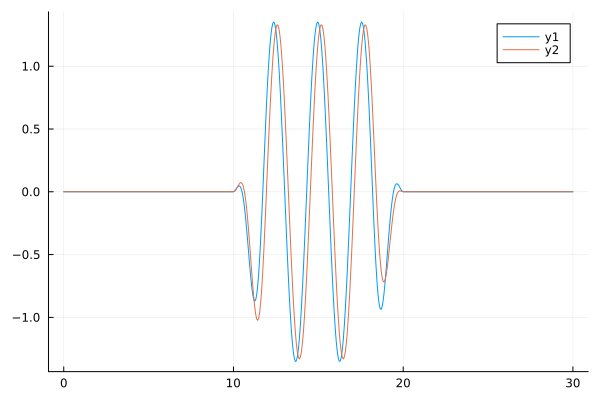

In [164]:
times = LinRange(0,30.0,500)

plot(times,[[pulse(p_new,t,buffer[1], buffer[2]) for t in times],
            [pulse([2, 10, 10, 0.7, 0.0, 0.978, 1.0, phi_ext, 0],t,buffer[1], buffer[2]) for t in times]])

In [166]:
forward_prob = ODEProblem(wrapper_H_int!(buffer), buffer[4][:,1:2], (0.0, 30.0), p_new)
sol_new = solve(forward_prob, p=p_new, saveat=LinRange(0,30.0,1000), reltol=1e-10, abstol=1e-12)

retcode: Success
Interpolation: 1st order linear
t: 1000-element Vector{Float64}:
  0.0
  0.03003003003003003
  0.06006006006006006
  0.09009009009009009
  0.12012012012012012
  0.15015015015015015
  0.18018018018018017
  0.21021021021021022
  0.24024024024024024
  0.2702702702702703
  ⋮
 29.75975975975976
 29.78978978978979
 29.81981981981982
 29.84984984984985
 29.87987987987988
 29.90990990990991
 29.93993993993994
 29.96996996996997
 30.0
u: 1000-element Vector{Matrix{ComplexF64}}:
 [8.185970273951507e-11 + 7.413378789586579e-10im 6.45528930795241e-10 + 3.109968151302549e-10im; 2.9177749139400264e-9 + 4.456858628671958e-9im 3.0355289001581973e-9 + 4.173048074201297e-9im; … ; -1.875068783929846e-9 + 4.986092315850066e-9im 5.155313967721894e-9 - 2.2694426182649146e-10im; 8.185974837113782e-11 + 7.413378566849499e-10im 6.455291491749273e-10 + 3.109966422412454e-10im]
 [-5.817039566995249e-10 - 4.665786925253679e-10im -6.64717415711737e-10 + 2.6719464960521127e-10im; -5.212954599209379

In [170]:
occs = zeros(Float64,1000,2,2)
tmpPot3 = buffer[3]
for (i,t) in enumerate(sol_new.t)
    tmpEs, tmpψs = eigs(KinPot12 + alpha(p_new,t) .* buffer[3], nev=2, which=:SR)
    occs[i,:,:] = abs2.(tmpψs'*sol_new.u[i])
end

In [206]:
zero = cat(occs[:,:,1],abs.(1 .- sum(occs,dims=2)[:,1,[1]]),dims=2)
one = cat(occs[:,:,2],abs.(1 .- sum(occs,dims=2)[:,1,[2]]),dims=2);

In [ ]:
# The optimized pulse:
# [Tᵣ, Tₐ, Tₚ, αmin, ϕ, f, A, Φ_ext, λ]
# 2.0
# 10.0
# 10.0
# 0.7
# 0.5418050115404741
# 0.9762975433042059
# 1.015560374248532
# 3.1258846903218442
# 0.052891229797236636

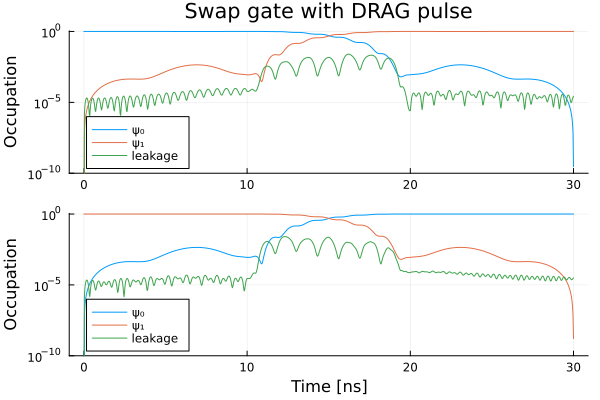

In [240]:
pzero = plot(sol_new.t,zero,title="Swap gate with DRAG pulse")
pone = plot(sol_new.t,one,xlabel="Time [ns]")

# plot(sol_new.t, [zero,one],yaxis=:log,ylims=(1e-10,1.1),layout=(2,1))
outputplot = plot(pzero,pone,
     layout=(2,1),
     yaxis=:log,
     ylims=(1e-10,1.1),
     legend=:bottomleft,
     label=["ψ₀" "ψ₁" "leakage"],
     ylabel="Occupation")

In [241]:
# savefig(outputplot,"Figures/SwapOptPulse07alpha.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\JuliaStuff\\Figures\\SwapOptPulse07alpha.pdf"